In [1]:
from IPython.display import Image, display

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

In [2]:
model = ChatGroq(temperature=0, model_name= "llama-3.3-70b-versatile")

In [3]:
# State 
class State(MessagesState):
    summary: str

In [4]:
# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"
    
    

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    print(f">>> summary_message: {summary_message}")
    print(f">>> summary_content: {response}")
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


In [5]:
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

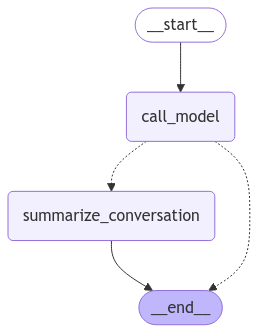

In [6]:
# Define a new graph
workflow = StateGraph(State)
workflow.add_node("call_model", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "call_model")
workflow.add_conditional_edges("call_model", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="한국의 수도는?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

한국의 수도는?
---------------------------------------------------------------------------
================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
---------------------------------------------------------------------------


In [8]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="일본의 수도는?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
================================ Human Message =================================

일본의 수도는?
---------------------------------------------------------------------------
================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
================================ Human Message =================================

일본의 수도는?
================================== Ai Message ==================================

일본의 수도는 도쿄입니다.
---------------------------------------------------------------------------


In [9]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="중국의 수도는?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
================================ Human Message =================================

일본의 수도는?
================================== Ai Message ==================================

일본의 수도는 도쿄입니다.
================================ Human Message =================================

중국의 수도는?
---------------------------------------------------------------------------
================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
================================ Human Message =================================

일본의 수도는?
================================== Ai Message ==================================

일본의 수도는 도쿄입니다.
================================ Human Message =================================


In [10]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="미국의 수도는??")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
================================ Human Message =================================

일본의 수도는?
================================== Ai Message ==================================

일본의 수도는 도쿄입니다.
================================ Human Message =================================

중국의 수도는?
================================== Ai Message ==================================

중국의 수도는 베이징입니다.
================================ Human Message =================================

미국의 수도는??
---------------------------------------------------------------------------
================================ Human Message =================================

한국의 수도는?
================================== Ai Message ==================================

한국의 수도는 서울입니다.
================================ Human Message ================================

In [11]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="베트남의 수도는??")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

미국의 수도는??
================================== Ai Message ==================================

미국의 수도는 워싱턴 D.C.입니다.
================================ Human Message =================================

베트남의 수도는??
---------------------------------------------------------------------------
================================ Human Message =================================

미국의 수도는??
================================== Ai Message ==================================

미국의 수도는 워싱턴 D.C.입니다.
================================ Human Message =================================

베트남의 수도는??
================================== Ai Message ==================================

베트남의 수도는 하노이입니다.
---------------------------------------------------------------------------


In [12]:
# Start conversation, again
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="수도들 사이의 거리는?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

미국의 수도는??
================================== Ai Message ==================================

미국의 수도는 워싱턴 D.C.입니다.
================================ Human Message =================================

베트남의 수도는??
================================== Ai Message ==================================

베트남의 수도는 하노이입니다.
================================ Human Message =================================

수도들 사이의 거리는?
---------------------------------------------------------------------------
================================ Human Message =================================

미국의 수도는??
================================== Ai Message ==================================

미국의 수도는 워싱턴 D.C.입니다.
================================ Human Message =================================

베트남의 수도는??
================================== Ai Message ==================================

베트남의 수도는 하노이입니다.
================================ Human Message ========